# **Final Project - Task 1:** PySpark Implementation of Recommendation System

## **About the dataset** - Vehicle CO2 Emissions Dataset

---

This dataset contains information on vehicle specifications, fuel consumption, and CO2 emissions, collected to analyze the environmental impact of vehicles and predict their CO2 emissions using regression models. The dataset is structured to support both Simple Linear Regression (SLR) and Multiple Linear Regression (MLR) approaches for machine learning projects.

**Key Features**

- `Brand`: The brand or manufacturer of the vehicle (e.g., Toyota, Ford, BMW).
- `Vehicle Type`: Classification of vehicles based on size and usage (e.g., SUV, Sedan).
- `Engine Size (L)`: Engine displacement volume in liters.
- `Cylinders`: Number of cylinders in the engine.
- `Transmission`: Type of transmission (e.g., Automatic, Manual).
- `Fuel Type`: Type of fuel used by the vehicle (e.g., Gasoline, Diesel, Hybrid).
- `Fuel Consumption (City, Hwy, and Combined)`: Fuel efficiency measured in liters per 100 kilometers (L/100 km).
- `CO2 Emissions (g/km)`: Carbon dioxide emissions per kilometer (target variable for prediction).

## **Importing the basics**

In [1]:
import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from pyspark.sql import SparkSession

#### **Starting the Spark session**

In [3]:
spark = SparkSession.builder.appName('Final Project Big Data').getOrCreate()

In [4]:
spark

In [5]:
df = spark.sql ("select 'spark' as hello")
df.show(5)

+-----+
|hello|
+-----+
|spark|
+-----+



#### **Mounting the Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls "drive/MyDrive/Colab Notebooks/FinalProject_BigData/co2.csv"

'drive/MyDrive/Colab Notebooks/FinalProject_BigData/co2.csv'


#### **Reading the dataset**

In [8]:
df = spark.read.csv('drive/MyDrive/Colab Notebooks/FinalProject_BigData/co2.csv', inferSchema = True, header=True)

In [9]:
type(df)

pyspark.sql.classic.dataframe.DataFrame

In [10]:
df.show()
df.printSchema()

+------------+------------+-------------+--------------+---------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|        Make|       Model|Vehicle Class|Engine Size(L)|Cylinders|Transmission|Fuel Type|Fuel Consumption City (L/100 km)|Fuel Consumption Hwy (L/100 km)|Fuel Consumption Comb (L/100 km)|Fuel Consumption Comb (mpg)|CO2 Emissions(g/km)|
+------------+------------+-------------+--------------+---------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|       ACURA|         ILX|      COMPACT|           2.0|        4|         AS5|        Z|                             9.9|                            6.7|                             8.5|                         33|                196|
|       ACURA|         ILX|      COMPACT|           2.4|

In [11]:
df.describe().show()

+-------+-----+-----------------+---------------+------------------+------------------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|summary| Make|            Model|  Vehicle Class|    Engine Size(L)|         Cylinders|Transmission|Fuel Type|Fuel Consumption City (L/100 km)|Fuel Consumption Hwy (L/100 km)|Fuel Consumption Comb (L/100 km)|Fuel Consumption Comb (mpg)|CO2 Emissions(g/km)|
+-------+-----+-----------------+---------------+------------------+------------------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|  count| 7385|             7385|           7385|              7385|              7385|        7385|     7385|                            7385|                           7385|                            7385|                     

## **Data cleaning**

---

For the cleaning phase I will create a copy of the original Dataframe, which will contain all the changes made on the data for the purpose of cleaning it.

In [12]:
df_cleaned = df.select([c for c in df.columns])

#### **Renaming columns**

The column names contain spaces and symbols that are not tolerated by some transformers I will use later on in the project (e.g. stringIndexer). This is the reason why I will rename them.



In [13]:
rename_map = {
    "Make": "make",
    "Model": "model",
    "Vehicle Class": "vehicle_class",
    "Engine Size(L)": "engine_size",
    "Cylinders": "cylinders",
    "Transmission": "transmission",
    "Fuel Type": "fuel_type",
    "Fuel Consumption City (L/100 km)": "fuel_consumption_city",
    "Fuel Consumption Hwy (L/100 km)": "fuel_consumption_hwy",
    "Fuel Consumption Comb (L/100 km)": "fuel_consumption_comb",
    "Fuel Consumption Comb (mpg)": "fuel_consumption_comb_mpg",
    "CO2 Emissions(g/km)": "co2_emissions"
}

for old, new in rename_map.items():
    df_cleaned = df_cleaned.withColumnRenamed(old, new)


In [14]:
df_cleaned.printSchema()

root
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- vehicle_class: string (nullable = true)
 |-- engine_size: double (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- fuel_consumption_city: double (nullable = true)
 |-- fuel_consumption_hwy: double (nullable = true)
 |-- fuel_consumption_comb: double (nullable = true)
 |-- fuel_consumption_comb_mpg: integer (nullable = true)
 |-- co2_emissions: integer (nullable = true)



#### **Converting data types**

In PySpark, double uses 8 bytes per value, while float uses 4 bytes per value. In this situation (where exact numbers would not make a difference in the performance of the recommendation algorithm) it would be wise to use `float` instead of `double` for some features to reduce computational cost.

In [15]:
from pyspark.sql.types import FloatType

In [16]:
cols = [
    "engine_size",
    "fuel_consumption_city",
    "fuel_consumption_hwy",
    "fuel_consumption_comb",
    "fuel_consumption_comb_mpg",
    "co2_emissions"
]

In [17]:
for c in cols:
    df_cleaned = df_cleaned.withColumn(c, df_cleaned[c].cast(FloatType()))

df_cleaned.printSchema()

root
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- vehicle_class: string (nullable = true)
 |-- engine_size: float (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- fuel_consumption_city: float (nullable = true)
 |-- fuel_consumption_hwy: float (nullable = true)
 |-- fuel_consumption_comb: float (nullable = true)
 |-- fuel_consumption_comb_mpg: float (nullable = true)
 |-- co2_emissions: float (nullable = true)



#### **Handling missing values**

In [18]:
from pyspark.sql.functions import isnan, when, count, col

In [21]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|make|model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|   0|    0|            0|          0|        0|           0|        0|                    0|                   0|                    0|                        0|            0|
+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+



**Observation:** As you can see, there are no missing values in any of the columns of the dataset. However, as a precaution, I will also check if strings such as 'NONE' or 'Nan' are hidden in the data.

In [27]:
df_cleaned.select([count(when(col(c).contains('None') | col(c).contains('NULL') | col(c).isNull(), c )).alias(c) for c in df_cleaned.columns]).show()

+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|make|model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|   0|    0|            0|          0|        0|           0|        0|                    0|                   0|                    0|                        0|            0|
+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+



**The data is safe! :)**

#### **Cleaning the `make` and `model` columns**

Before I will handle the duplication in this dataset (see next section), I think it is necessary to clean the columns that contain `strings`.

For example, there can be 2 columns that have the exact same data, but the only difference is that in the `make` column one row has the brand written in capital letters, while the other one in lowercase.

Will the `dropDuplicates()` function see the duplication in this case?
No, dropDuplicates() cannot automatically ignore case differences. Therefore, these string columns need to be cleaned first and normalised (e.g all values in uppercase or lowercase or first letter capitalized).

In [25]:
df_cleaned.where(df_cleaned.make == "BUGATTI").show()

+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|   make| model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|BUGATTI|CHIRON|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.8|                16.6|                 22.2|                     13.0|        522.0|
|BUGATTI|Chiron|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.8|                16.6|                 22.2|                     13.0|        522.0|
|BUGATTI|Chiron|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.

**Observation:** As you can see in the example above, all values are identical for these rows, with the only exception that the `model` is written in a different case. I will change all entries in the `make` and `model` columns to UPPERCASE.

In [28]:
from pyspark.sql.functions import upper, trim

df_cleaned = (df_cleaned.withColumn("make", upper(trim(col("make")))).withColumn("model", upper(trim(col("model")))))


In [29]:
df_cleaned.where(df_cleaned.make == "BUGATTI").show()

+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|   make| model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|BUGATTI|CHIRON|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.8|                16.6|                 22.2|                     13.0|        522.0|
|BUGATTI|CHIRON|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.8|                16.6|                 22.2|                     13.0|        522.0|
|BUGATTI|CHIRON|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.

#### **Cleaning the `vehicle_class` column**

The `vehicle_class` column is an incredibly important column for this project. It is one of the most important aspects that a user takes into consideration when buying a car.

In [30]:
df_cleaned.select("vehicle_class").distinct().show(truncate = 50)

+------------------------+
|           vehicle_class|
+------------------------+
|             MINICOMPACT|
| SPECIAL PURPOSE VEHICLE|
|                 COMPACT|
|             VAN - CARGO|
|          SUV - STANDARD|
|             SUV - SMALL|
| PICKUP TRUCK - STANDARD|
|STATION WAGON - MID-SIZE|
|              TWO-SEATER|
|              SUBCOMPACT|
|                MID-SIZE|
|    PICKUP TRUCK - SMALL|
|               FULL-SIZE|
|   STATION WAGON - SMALL|
|                 MINIVAN|
|         VAN - PASSENGER|
+------------------------+



**Observation:** You can notice that the categories are VERY specific. In this case the question would be: should I merge the categories or leave them as they are?

In my opinion, they should be left as they are for the following reason: when building a recommendation system is important that the recommandations are as specific as possible to the user's needs and preferences. For example, the user wants to buy a cargo van, but I merge the `VAN - CARGO` and `VAN - PASSENGER` categories. In this case the user might get recommendations of passenger vans, when he is not interested to buy one.

This is why I will only `rename` the categories of this column, but I will not merge any of them.

In [31]:
vehicle_class_map = {
    "SUV - SMALL": "SUV_SMALL",
    "SUV - STANDARD": "SUV_STANDARD",
    "STATION WAGON - MID-SIZE": "STATION_WAGON_MIDSIZE",
    "STATION WAGON - SMALL": "STATION_WAGON_SMALL",
    "PICKUP TRUCK - SMALL": "PICKUP_TRUCK_SMALL",
    "PICKUP TRUCK - STANDARD": "PICKUP_TRUCK_STANDARD",
    "SPECIAL PURPOSE VEHICLE": "SPECIAL_PURPOSE",
    "MINIVAN": "MINIVAN",
    "VAN - PASSENGER": "PASSENGER_VAN",
    "VAN - CARGO": "CARGO_VAN"
}


In [32]:
for old, new in vehicle_class_map.items():
    df_cleaned = df_cleaned.withColumn("vehicle_class", when(col("vehicle_class") == old, new).otherwise(col("vehicle_class")))

In [33]:
df_cleaned.select("vehicle_class").distinct().show(truncate = 50)

+---------------------+
|        vehicle_class|
+---------------------+
|      SPECIAL_PURPOSE|
|STATION_WAGON_MIDSIZE|
|          MINICOMPACT|
|PICKUP_TRUCK_STANDARD|
|              COMPACT|
|   PICKUP_TRUCK_SMALL|
|           TWO-SEATER|
|  STATION_WAGON_SMALL|
|           SUBCOMPACT|
|             MID-SIZE|
|         SUV_STANDARD|
|            CARGO_VAN|
|            SUV_SMALL|
|            FULL-SIZE|
|        PASSENGER_VAN|
|              MINIVAN|
+---------------------+



#### **Handling duplicates**

In [34]:
df_cleaned.groupBy(df_cleaned.columns).count().filter("count > 1").show(truncate=False)


+-------------+-------------------+---------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+-----+
|make         |model              |vehicle_class        |engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|count|
+-------------+-------------------+---------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+-----+
|MERCEDES-BENZ|E 550 CABRIOLET    |SUBCOMPACT           |4.7        |8        |AS7         |Z        |13.7                 |9.2                 |11.7                 |24.0                     |275.0        |2    |
|CADILLAC     |ATS AWD            |COMPACT              |2.0        |4        |AS8         |Z        |10.8                 |7.9                 

In [35]:
df_cleaned.where((df_cleaned.make == "ASTON MARTIN") & (df_cleaned.model =="V8 VANTAGE") & (df_cleaned.transmission == "AM7")).show()

+------------+----------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|        make|     model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+------------+----------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|ASTON MARTIN|V8 VANTAGE|   TWO-SEATER|        4.7|        8|         AM7|        Z|                 17.4|                11.3|                 14.7|                     19.0|        338.0|
|ASTON MARTIN|V8 VANTAGE|   TWO-SEATER|        4.7|        8|         AM7|        Z|                 17.4|                11.3|                 14.7|                     19.0|        338.0|
|ASTON MARTIN|V8 VANTAGE|   TWO-SEATER|        4.7

**Observation:**

As you can see in the Aston Martin example that I showed above, we can already notice that we have `total duplicates` (identical columns), but also what seem to be `partial duplicates` (only certain columns are different).
Total duplicates are easy to deal with, we simply remove them.

Partial duplication might occur in this dataset (see the Aston Martin example above) when 2 cars of the same brand and model contain different specs. In real life this is possible: think of a car from the same brand and model, but different fabrication year (e.g. a Ford Focus from 2004 will not have the same specs as a Ford Focus from 2020). In this dataset the year or the ID of the car are NOT SPECIFIED, meaning that there shouldn't be any justification for these partial duplicates.

However, the way duplication is interpreted is more of a business problem, rather than a data analysis problem. For example, the data can be scrapped from a website that sells second-hand cars (which by looking at the data, seems to be the case here). In that case, we can have multiple posts for the same car (same model and brand) but with different specs.

To conclude, I will I will leave "partial duplicates as they are, and not drop them.

- Handling total duplicates:

In [36]:
total_rows = df_cleaned.count()
distinct_rows = df_cleaned.distinct().count()

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Total duplicate rows: {total_rows - distinct_rows}")

Total rows: 7385
Distinct rows: 5990
Total duplicate rows: 1395


In [37]:
df_cleaned = df_cleaned.dropDuplicates()

In [38]:
total_rows = df_cleaned.count()
distinct_rows = df_cleaned.distinct().count()

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Total duplicate rows: {total_rows - distinct_rows}")

Total rows: 5990
Distinct rows: 5990
Total duplicate rows: 0


#### **Dealing with outliers**

To begin with, what is an **outlier**? Many would say an outlier is anything that is outside the interquantilic range (if the IQR method is used), others would say it is an error in the data (values that simply don't make sense).

However, I believe that how we define an outlier depends on the data itself, while also being a "business problem".

For example, if the average `fuel_consumption_comb` value is 10.97 but we have a few rows with values such as 25.1, 25.7 etc. (see examples below in this section), do we eliminate them just because they can be considered outliers? Well, if you'll take a closer look at the data, you will notice that these rows have one thing in common: they all represent passenger vans! And passenger vans are supposed to have a higher consumption, right? Eliminating these rows would eliminate important information about the distribution of the data. So this is not a option...

**Observation:** For visualisation of the outliers I will use an overlapping `boxplot` and `violinplot` combo. I will also inspect the distribution of the continuous data using a histogram in later stages of the project (see EDA section).

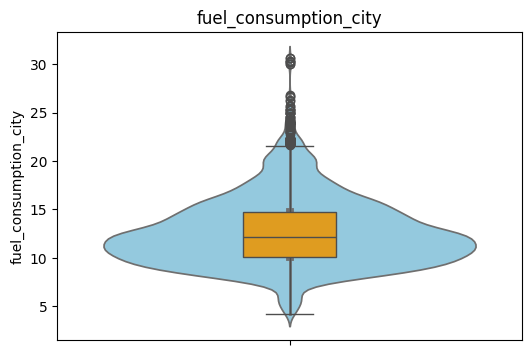

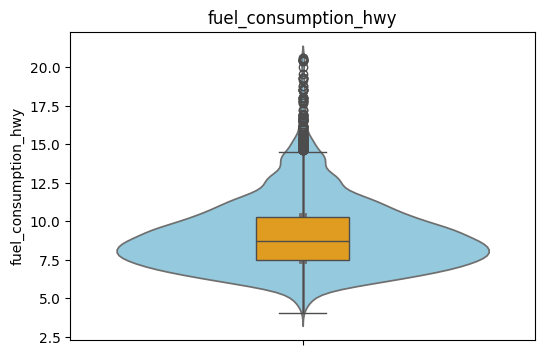

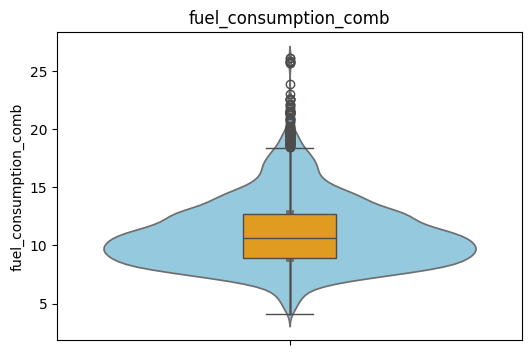

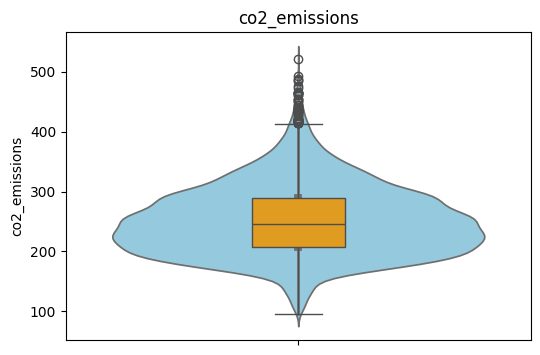

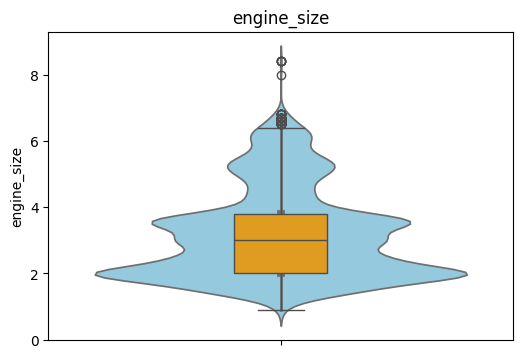

In [39]:
cols_to_visualise = ["fuel_consumption_city", "fuel_consumption_hwy", "fuel_consumption_comb", "co2_emissions", "engine_size"]
pdf = df_cleaned.select(cols_to_visualise).dropna().toPandas()

for c in cols_to_visualise:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=pdf[c], color="skyblue")
    sns.boxplot(y=pdf[c], width=0.2, color="orange")
    plt.title(c)
    plt.show()

**Observation:** You can notice in most of the columns there are isolated groups of dots that might be outliers. I will inspect these further to look for any patterns that could explain why these values are higher, or to identify possible errors in the data. For this I will set thresholds (based on the visual inspection of the plots) and filter the values above that threshold (those will be the possible outliers).

In [40]:
thresholds = {
    "fuel_consumption_city": 28,
    "fuel_consumption_hwy": 18,
    "fuel_consumption_comb": 25,
    "co2_emissions": 500,
    "engine_size": 7
}

for c, t in thresholds.items():
    extreme_rows = df_cleaned.filter(col(c) > t)
    print(f"\nExtreme rows for column: {c}")
    extreme_rows.show(truncate=False)



Extreme rows for column: fuel_consumption_city
+---------+--------------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|make     |model                     |vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|fuel_consumption_comb_mpg|co2_emissions|
+---------+--------------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------------------+-------------+
|CHEVROLET|EXPRESS 2500 PASSENGER    |PASSENGER_VAN|6.0        |8        |A6          |E        |30.0                 |20.4                |25.7                 |11.0                     |411.0        |
|GMC      |SAVANA 2500 PASSENGER FFV |PASSENGER_VAN|6.0        |8        |A6          |E        |30.3                 |20.5                |

**Observation:**
As expected, in the examples above you can see patterns: the cars with high `fuel consumption` are all vans (mostly passenger, but also cargo) or trucks, which totally makes sense (the bigger the vehicle, the higher the consumption).

As for the engine size and co2 emissions outliers, we can see that they are somehow related. Outliers that have big engine size also tend to have a higher co2 consumption, and they have one thing in common: they represent `two-seaters`, powerful cars with big engines.

As I mentioned before, dropping these rows would be completely wrong as they offer priceless insight into the distribution of the data.

**Then, how to handle the outliers?** In the later stages of the project, I will scale these numerical features using the most appropriate tool given the nature of the data:
- few extreme values;
- outliers are representative and meaningful (they represent distinct categories in the data);
- it is important to preserve the differences in the data for the reccomendation task;
- most features have right-skewed distributions.

#### **Inspect `fuel_consumption_comb`**

It can be seen that the `fuel_consumption_comb` feature seems to be related to the other 2: `fuel_consumption_city` and `fuel_consumption_hwy`. I will inspect if that is the case. Most probably it is an average of the 2.

In [41]:
from pyspark.sql.functions import round

# Create a new column with the average of city and highway consumption
df_check = df_cleaned.withColumn("average_city_hwy", round((col("fuel_consumption_city") + col("fuel_consumption_hwy")) / 2, 2))

# Select relevant columns to compare
df_check.select("fuel_consumption_city", "fuel_consumption_hwy", "fuel_consumption_comb", "average_city_hwy").show(10, truncate=False)


+---------------------+--------------------+---------------------+----------------+
|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|average_city_hwy|
+---------------------+--------------------+---------------------+----------------+
|14.6                 |9.8                 |12.4                 |12.2            |
|10.8                 |7.1                 |9.1                  |8.95            |
|11.7                 |8.6                 |10.3                 |10.15           |
|15.7                 |9.5                 |12.9                 |12.6            |
|18.8                 |12.6                |16.0                 |15.7            |
|14.7                 |9.5                 |12.4                 |12.1            |
|8.4                  |8.3                 |8.4                  |8.35            |
|10.4                 |6.8                 |8.8                  |8.6             |
|11.9                 |8.9                 |10.5                 |10.4      

**Observation:**

It can be noticed that, while `fuel_consumption_comb` is not an average between the `fuel_consumption_city` and `fuel_consumption_hwy`, values are still very close. So maybe a weighted average was used when the combined values were calculated, however I have no way of knowing the formula behind it.

The question is, though, can I use all these 3 features with Cosine similarity? Well, cosine similarity measures the angle between two feature vectors in multi-dimensional space. Therefore, features that are highly correlated or redundant can bias similarity. And we know that `fuel_consumption_comb` is somehow derived from the other 2. Therefore I should choose whether:
1. I use `fuel_consumption_city` and `fuel_consumption_hwy`, but NOT `fuel_consumption_comb`
2. I use `fuel_consumption_comb` but NOT `fuel_consumption_city` and `fuel_consumption_hwy`

And my choice is **1**, because this option preserves the differences between consumption in the city and consumption outside the city (which as it can be seen in examples, are sometimes HUGE). I think these differences are crucial for getting good recommendations.

I will not drop this column, but I will not include it in the calculation of Cosine similarity. However, I will drop `fuel_consumption_comb_mpg` because it is measured in the units used in USA, and in my project I will use only the features measured in **L/100km** (European units of measurement).

In [42]:
df_eda = df_cleaned.drop("fuel_consumption_comb_mpg")
df_eda.show()
df_eda.printSchema()


+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|
+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|
|          BMW|        Z4 SDRIVE28I|        TWO-SEATER|        2.0|        4|          A8|        Z|                 10.8|                 7.1|                  9.1|        209.0|
|       TOYOTA|          HIGHLANDER|         SUV_SMALL|        2.7|        4|         AS6|        X|

## **Exploratory Data Analysis**

---

In this part of the project I will explore the data, in order to answer a very important question: **Which aspects do co2 emissions depend on?**
Moreover, I will explore a bit more in detail the features that I will use, in order to see what kind of preprocessing is needed for the recommendation system.

In this phase of the project I will use `df_eda`.


In [43]:
unique_counts = {c: df_eda.select(c).distinct().count() for c in df_eda.columns}
data = [(k, v) for k, v in unique_counts.items()]
unique_df = spark.createDataFrame(data, ["column_name", "unique_count"])
unique_df.show()

+--------------------+------------+
|         column_name|unique_count|
+--------------------+------------+
|                make|          42|
|               model|        1591|
|       vehicle_class|          16|
|         engine_size|          51|
|           cylinders|           8|
|        transmission|          27|
|           fuel_type|           5|
|fuel_consumption_...|         211|
|fuel_consumption_hwy|         143|
|fuel_consumption_...|         181|
|       co2_emissions|         331|
+--------------------+------------+



**Observation:**

We can notice that the `make` and `model` columns have many values so even if they are categorical, I cannot encode them.

Also, I believe that including them in the vectors for Cosine similarity would be wrong because it might bias the algorithm. For example, if someone is looking for Chevrolet compact car, they my get a recommendation of a Chevrolet minivan (if it has similar specs) just because of the model.

Therefore I will choose to exclude **make** and **model** from the Cosine algorithm.

#### **Exploring discrete variables**

`Discrete` refers to everything that is **countable** in the dataset (categorical or numeric):
- `make` → BMW, AUDI, etc.
- `model` → SONATA, YARIS etc.
- `vehicle_class` → SUV_SMALL, COMPACT, etc.
- `cylinders` → 2, 4, 8 etc. → this is **NUMERIC**
- `transmission` → A4, A6, A8, M6, AM6, etc.
- `fuel_type` → X, Z, E, D






* Checking unique values in the discrete variables

In [44]:
from os import truncate
columns_to_check = ["vehicle_class", "cylinders", "transmission", "fuel_type"]

for c in columns_to_check:
    print(f"Unique entries in column {c}:")
    n = unique_df.where(unique_df.column_name == c).collect()[0][1]
    df_eda.select(c).distinct().show(n, truncate=False)

Unique entries in column vehicle_class:
+---------------------+
|vehicle_class        |
+---------------------+
|SPECIAL_PURPOSE      |
|STATION_WAGON_MIDSIZE|
|MINICOMPACT          |
|PICKUP_TRUCK_STANDARD|
|COMPACT              |
|PICKUP_TRUCK_SMALL   |
|TWO-SEATER           |
|STATION_WAGON_SMALL  |
|SUBCOMPACT           |
|MID-SIZE             |
|SUV_STANDARD         |
|CARGO_VAN            |
|SUV_SMALL            |
|FULL-SIZE            |
|PASSENGER_VAN        |
|MINIVAN              |
+---------------------+

Unique entries in column cylinders:
+---------+
|cylinders|
+---------+
|12       |
|6        |
|16       |
|3        |
|5        |
|4        |
|8        |
|10       |
+---------+

Unique entries in column transmission:
+------------+
|transmission|
+------------+
|AS4         |
|AS10        |
|A9          |
|AV10        |
|AM5         |
|A6          |
|M7          |
|A8          |
|AV          |
|AM9         |
|AS9         |
|AS6         |
|M6          |
|AV8         |
|AV6

* Counting rows in each category of the discrete variables

In [45]:
from pyspark.sql import functions as F

cols_to_check = ["vehicle_class", "fuel_type", "make", "cylinders", "transmission"]

for col in cols_to_check:
    print(f"Counts for {col}")
    (df_eda.groupBy(col).count().orderBy(F.desc("count")).show(truncate=False))


Counts for vehicle_class
+---------------------+-----+
|vehicle_class        |count|
+---------------------+-----+
|SUV_SMALL            |960  |
|MID-SIZE             |931  |
|COMPACT              |888  |
|SUV_STANDARD         |590  |
|SUBCOMPACT           |517  |
|FULL-SIZE            |471  |
|PICKUP_TRUCK_STANDARD|470  |
|TWO-SEATER           |352  |
|MINICOMPACT          |246  |
|STATION_WAGON_SMALL  |199  |
|PICKUP_TRUCK_SMALL   |118  |
|PASSENGER_VAN        |66   |
|SPECIAL_PURPOSE      |61   |
|MINIVAN              |54   |
|STATION_WAGON_MIDSIZE|45   |
|CARGO_VAN            |22   |
+---------------------+-----+

Counts for fuel_type
+---------+-----+
|fuel_type|count|
+---------+-----+
|X        |2877 |
|Z        |2641 |
|E        |325  |
|D        |146  |
|N        |1    |
+---------+-----+

Counts for make
+-------------+-----+
|make         |count|
+-------------+-----+
|FORD         |563  |
|CHEVROLET    |503  |
|BMW          |492  |
|MERCEDES-BENZ|363  |
|GMC          |278  

#### **Exploring continuous variables**

A `continuous variable` is a type of numerical variable that can take any value **within a range**. It is measurable rather than countable, and its values are not restricted to separate steps—they can be infinitely precise depending on the measurement.
- `fuel_consumption_city`
- `fuel_consumption_hwy`
- `CO2 emissions`


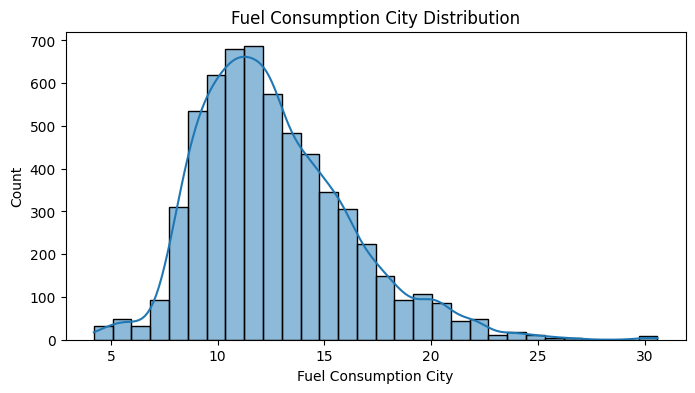

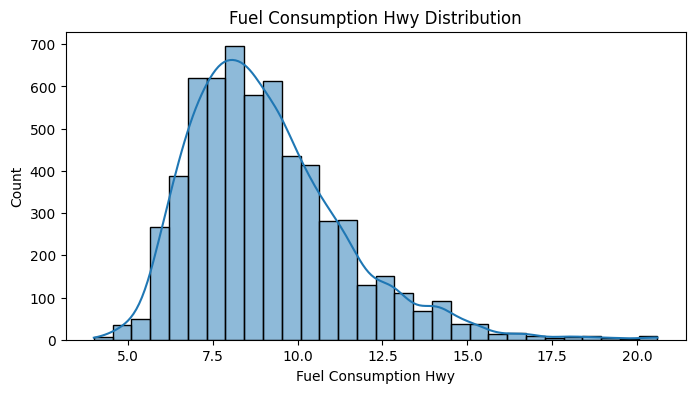

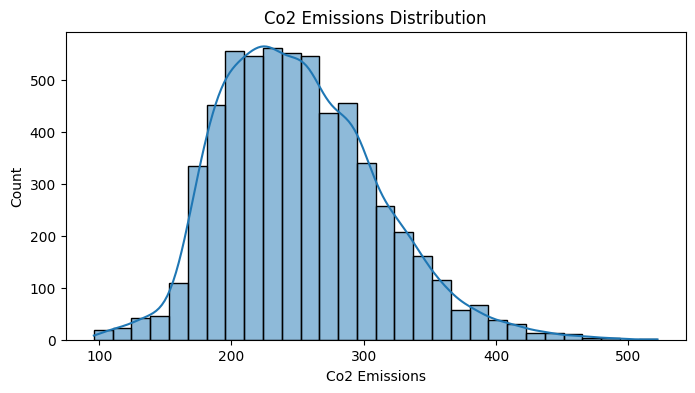

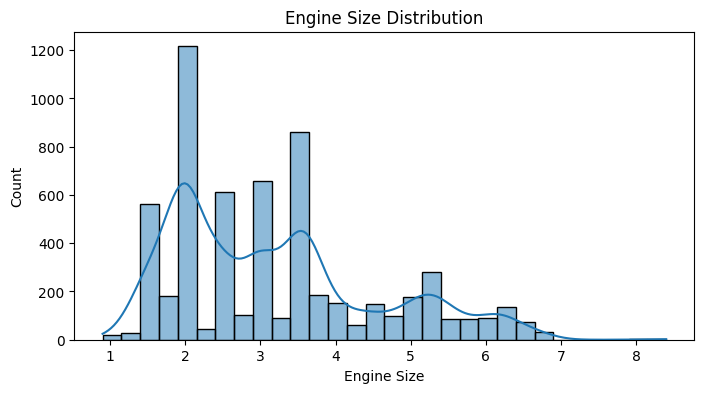

In [47]:
cols_to_visualise = ["fuel_consumption_city", "fuel_consumption_hwy", "co2_emissions", "engine_size"]
for col in cols_to_visualise:
    plt.figure(figsize=(8, 4))
    sns.histplot(pdf[col], bins=30, kde=True)
    plt.title(f"{col.replace('_', ' ').title()} Distribution")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Count")
    plt.show()

**Observation:**
It can be observed that the distributions of the `fuel consumption` features, as well as the `co2_emissions` are mildly skewed to the right. This is an important aspect in deciding which method to use for scaling later on in the preprocessing phase.
On the other hand, `engine_size` clearly shows a multimodal distribution (4 peaks can be detected), meaning that we can visually identify some subgroups in the distribution of the data.

In [48]:
numeric_cols = ["engine_size", "fuel_consumption_city", "fuel_consumption_hwy"]

for col in numeric_cols:
    corr = df_eda.stat.corr("co2_emissions", col)
    print(f"Correlation between CO2 emissions and {col}: {corr:.3f}")


Correlation between CO2 emissions and engine_size: 0.854
Correlation between CO2 emissions and fuel_consumption_city: 0.917
Correlation between CO2 emissions and fuel_consumption_hwy: 0.881


**Observation:** Above you can see the corelation between some numeric variables. This tells us that there is a very strong connection between CO2 emissions and fuel consumption, as well as engine size. In other words, they have a strong influence on each other.

**Analysing patterns in `co2_emissions` based on `fuel_type`**

According to information found on Google, the `fuel_type` values can have the following meaning:

- `X`: Regular gasoline (petrol). In some car models (e.g., Maruti Suzuki), it can also indicate a petrol version/trim level of a car.
- `Z`: Premium gasoline (premium unleaded petrol). It is an octane-rated fuel, often 97+ octane. In some car models, it can also refer to a high-trim/luxurious variant of the car.
- `E`: Ethanol, commonly an E85 blend (85% ethanol) used in flexible-fuel vehicles. In the EU fuel labeling system, E with a number (e.g., E5, E10) refers to the percentage of ethanol in the petrol.
- `D`: Diesel. This notation is widely used across various systems and car models to denote a diesel engine or variant.
- `N`: Natural Gas (CNG or LNG).

In [49]:
df_eda.groupBy("fuel_type").count().orderBy(F.desc("count")).show(truncate=False)

+---------+-----+
|fuel_type|count|
+---------+-----+
|X        |2877 |
|Z        |2641 |
|E        |325  |
|D        |146  |
|N        |1    |
+---------+-----+



/tmp/ipython-input-1793172540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_co2.index, y=mean_co2.values, palette="magma")


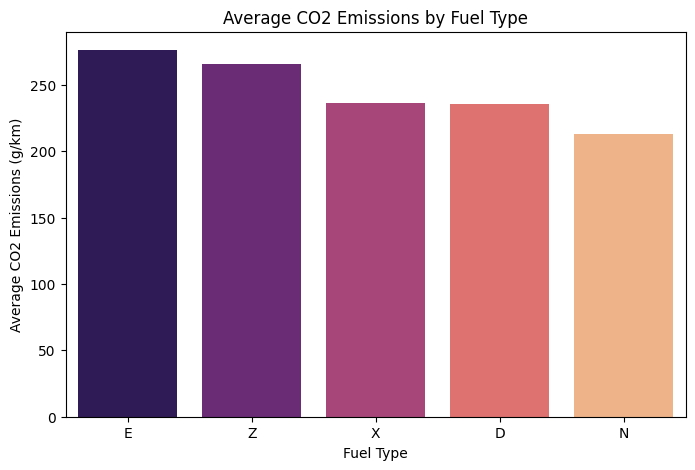

In [50]:
df_pd = df_eda.select("fuel_type", "co2_emissions").toPandas()

mean_co2 = df_pd.groupby("fuel_type")["co2_emissions"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=mean_co2.index, y=mean_co2.values, palette="magma")
plt.title("Average CO2 Emissions by Fuel Type")
plt.ylabel("Average CO2 Emissions (g/km)")
plt.xlabel("Fuel Type")
plt.show()


**Observation:**
You can notice that on average the highest consumption is for the Ethanol type, followed by premium gasoline and regular gasoline. The lowest consumptuion is given by diesel cars and the ones using natural gas.
However, we have to consider the differences in counts (see little table above). While for X we can compute a "real" average, for N the average will be the only element that exists in the dataset with this value.

**Analysing patterns in `co2_emissions` based on `vehicle_class`**

In [51]:
df_eda.groupBy("vehicle_class").count().orderBy(F.desc("count")).show(truncate=False)

+---------------------+-----+
|vehicle_class        |count|
+---------------------+-----+
|SUV_SMALL            |960  |
|MID-SIZE             |931  |
|COMPACT              |888  |
|SUV_STANDARD         |590  |
|SUBCOMPACT           |517  |
|FULL-SIZE            |471  |
|PICKUP_TRUCK_STANDARD|470  |
|TWO-SEATER           |352  |
|MINICOMPACT          |246  |
|STATION_WAGON_SMALL  |199  |
|PICKUP_TRUCK_SMALL   |118  |
|PASSENGER_VAN        |66   |
|SPECIAL_PURPOSE      |61   |
|MINIVAN              |54   |
|STATION_WAGON_MIDSIZE|45   |
|CARGO_VAN            |22   |
+---------------------+-----+



/tmp/ipython-input-3550965452.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_co2.index, y=mean_co2.values, palette="viridis")


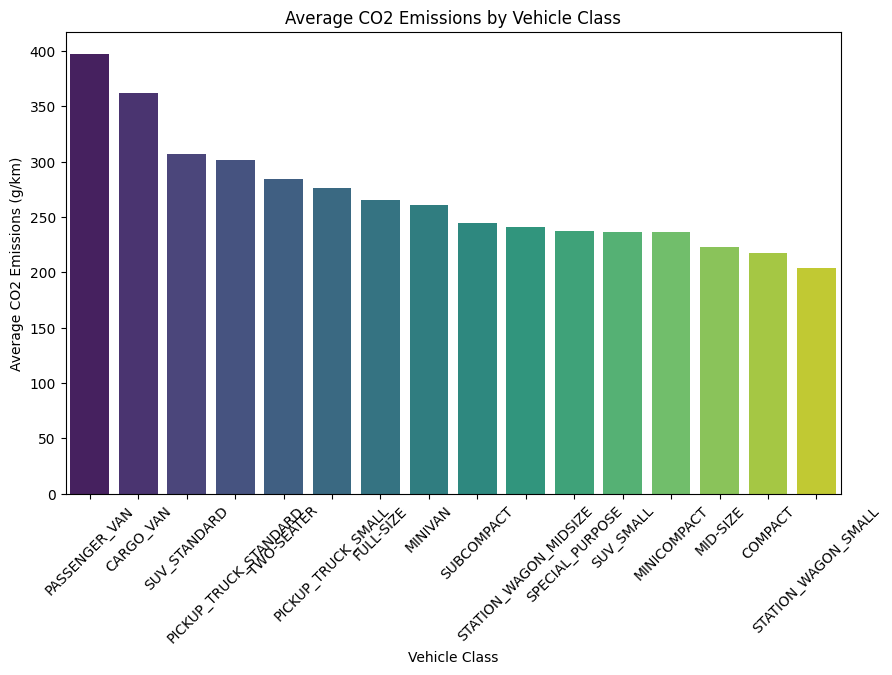

In [52]:
df_pd = df_eda.select("vehicle_class", "co2_emissions").toPandas()

mean_co2 = df_pd.groupby("vehicle_class")["co2_emissions"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=mean_co2.index, y=mean_co2.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Average CO2 Emissions by Vehicle Class")
plt.ylabel("Average CO2 Emissions (g/km)")
plt.xlabel("Vehicle Class")
plt.show()


**Observation:** In the plot above you can see that on average "big" vehicles such as vans, SUVs and trucks - with one exception, the two-seaters, powerful cars with big engines and high fuel consumption - have the highest CO2 emissions.

## **Preprocessing**

---

In this stage of the project I will mainly prepare the dataset for Cosine similarity, by performing the following operations:
- adding an ID column to the dataset for easier identification of the rows;
- encoding discrete variables using **OneHotEncoder**;
- scaling numeric continuous features using **StandardScaler** (for `engine_zise`) and **RobustScaler** (for `fuel_consumption_city`, `fuel_consumption_hwy` and `co2_emissions`)

These operations are to be performed on the `df_preproc` dataset.

In [53]:
df_preproc = df_eda.select([c for c in df_eda.columns])
df_preproc.show()

+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|
+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|
|          BMW|        Z4 SDRIVE28I|        TWO-SEATER|        2.0|        4|          A8|        Z|                 10.8|                 7.1|                  9.1|        209.0|
|       TOYOTA|          HIGHLANDER|         SUV_SMALL|        2.7|        4|         AS6|        X|

#### **Adding an `ID column`**
**Why is it necessary?**
I added an ID column to my dataset to give each vehicle a unique identifier. This makes it easier to track and reference specific rows, especially when computing things like similarities or returning recommendations. Without it, it would be harder to tell which row corresponds to which vehicle, so the ID helps keep everything organized and clear.

In [54]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

w = Window.orderBy(F.lit(1))
df_preproc = df_preproc.withColumn("id", F.row_number().over(w) - 1)

df_preproc.show()

+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+---+
|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions| id|
+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+---+
|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|  0|
|          BMW|        Z4 SDRIVE28I|        TWO-SEATER|        2.0|        4|          A8|        Z|                 10.8|                 7.1|                  9.1|        209.0|  1|
|       TOYOTA|          HIGHLANDER|         SUV_SMALL|        2.7|        4|   

**Observation:** In PySpark (as well as in Python) a column is by default added at the end of the dataset. I will move it to the beginning of the dataset, which is the best position for an identificator.

In [55]:
cols = df_preproc.columns
new_order = ['id'] + [c for c in cols if c != 'id']
df_preproc = df_preproc.select(new_order)

df_preproc.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+
|  0|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|
|  1|          BMW|        Z4 SDRIVE28I|        TWO-SEATER|        2.0|        4|          A8|        Z|                 10.8|                 7.1|                  9.1|        209.0|
|  2|       TOYOTA|          HIGHLANDER|         SUV_SMALL|        2.7|        4

#### **`Encoding` discrete features**

I encoded the discrete features using **OneHotEncoder** because cosine similarity works with numerical vectors. Discrete categories are not naturally numerical, so encoding them as vectors allows the recommendation system to compare vehicles correctly. One-hot encoding preserves the distinctness of each category without implying any order, which is important to avoid misleading similarities. The following features are to be encoded:
- `vehicle_class`
- `cylinders`
- `transmission`
- `fuel_type`

In [56]:
discrete_cols = ["vehicle_class", "cylinders", "transmission", "fuel_type"]

**Observation:** Before applying OneHotEncoder, it is necessary to convert categorical string values into numeric indices using a `StringIndexer`. One-hot encoding in Spark works on numeric inputs, not strings, so the indexer assigns a unique number to each category. This ensures that each category can be correctly represented as a binary vector

In [57]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer

In [58]:
for c in discrete_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_index")
    df_preproc = indexer.fit(df_preproc).transform(df_preproc)

df_preproc.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+
|  0|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|                4.0|            1.0|               2

In [59]:
from pyspark.ml.feature import OneHotEncoder

indexed_cols = [c + "_index" for c in discrete_cols]
ohe_cols = [c + "_ohe" for c in discrete_cols]

encoder = OneHotEncoder(inputCols=indexed_cols, outputCols=ohe_cols)
df_preproc = encoder.fit(df_preproc).transform(df_preproc)

df_preproc.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|vehicle_class_ohe|cylinders_ohe|transmission_ohe|fuel_type_ohe|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+
|  0|         AUDI|                  S5|      

#### **`Scaling` continuous features**

Scaling continuous features is necessary because different numeric columns can have very different **ranges** (for example, engine size has values from around 1 to 8,4, while co2_emissions has much bigger values, from around 100 to around 500) or different **measurement scales** (liters vs grams per kilometer). If we don’t scale them, features with larger values could dominate the calculation of distances or similarities, such as in our cosine similarity-based recommendation system. By scaling, we bring all continuous features to a comparable range, ensuring that each feature contributes equally to the analysis. The scaling I use are the following:
- `StandardScaler` for **engine_size**
- `RobustScaler` for **fuel_consumption_city**, **fuel_consumption_hwy**, **co2_emissions**

**Observation:**
Using `VectorAssembler` is necessary before scaling because PySpark’s scaling methods, like `StandardScaler` or `RobustScaler`, expect a single vector column as input rather than multiple separate numeric columns. `VectorAssembler` combines all the selected continuous features into one vector, which allows the scaler to process them together and apply the same transformation consistently across all features. This ensures that each feature is properly scaled while maintaining the structure required for machine learning algorithms.


In [60]:
continuous_cols = ["engine_size", "fuel_consumption_city", "fuel_consumption_hwy", "co2_emissions"]

In [61]:
from pyspark.ml.feature import VectorAssembler
for col in continuous_cols:
    assembler = VectorAssembler(inputCols=[col], outputCol=col+"_vec")
    df_preproc = assembler.transform(df_preproc)

df_preproc.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+--------------------+-------------------------+------------------------+-----------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|vehicle_class_ohe|cylinders_ohe|transmission_ohe|fuel_type_ohe|     engine_size_vec|fuel_consumption_city_vec|fuel_consumption_hwy_vec|co2_emissions_vec|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-

**Why I chose different scaling tools?**  

I chose `StandardScaler` for **engine_size** because its values are relatively small, the distribution is multimodal, and there are only a few mild outliers. `StandardScaler` standardizes the data by removing the mean and scaling to unit variance, which works well when the feature distribution is roughly symmetric and the outliers are not extreme.  

For **fuel_consumption_city**, **fuel_consumption_hwy**, and **co2_emissions**, I used `RobustScaler` because these variables have a much larger range of values and are mildly skewed to the right with more pronounced outliers. `RobustScaler` scales the features based on the interquartile range, which makes it less sensitive to outliers, ensuring that extreme values do not dominate the scaling process.

In [62]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="engine_size_vec", outputCol="engine_size_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df_preproc)
df_preproc = scaler_model.transform(df_preproc)

df_preproc.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+--------------------+-------------------------+------------------------+-----------------+--------------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|vehicle_class_ohe|cylinders_ohe|transmission_ohe|fuel_type_ohe|     engine_size_vec|fuel_consumption_city_vec|fuel_consumption_hwy_vec|co2_emissions_vec|  engine_size_scaled|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+----------------

In [63]:
from pyspark.ml.feature import RobustScaler

features = ["fuel_consumption_city", "fuel_consumption_hwy", "co2_emissions"]

for f in features:
    scaler = RobustScaler(inputCol=f+"_vec", outputCol=f+"_scaled", withCentering=True, withScaling=True)
    scaler_model = scaler.fit(df_preproc)
    df_preproc = scaler_model.transform(df_preproc)

df_preproc.show()


+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+--------------------+-------------------------+------------------------+-----------------+--------------------+----------------------------+---------------------------+--------------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|vehicle_class_ohe|cylinders_ohe|transmission_ohe|fuel_type_ohe|     engine_size_vec|fuel_consumption_city_vec|fuel_consumption_hwy_vec|co2_emissions_vec|  engine_size_scaled|fuel_consumption_city_scaled|fuel_consumption_hwy_scaled|co2_emis

## **Building the Recommendation system using `Cosine Similarity`**

---

**What is Cosine Similarity?**
Cosine similarity is a measure that calculates how similar two vectors are by measuring the cosine of the angle between them. In other words, it quantifies the similarity between two items based on the direction of their feature vectors, rather than their magnitude.

`cosine_similarity(A,B)= A ⋅ B​ / ∥A∥ ⋅ ∥B∥`


`Dot product A⋅B`: measures how much the vectors point in the same direction

`Norm ∥A∥`: vector length (magnitude)

- 1 means the vectors point in exactly the same direction (very similar)
- 0 means they are orthogonal (completely unrelated)
- -1 means they point in opposite directions (maximally dissimilar)

In recommendation systems, cosine similarity is useful because it allows us to compare items with multiple features (like in this particular dataset) on a normalized scale, so we can identify which items are most alike regardless of the absolute values of their features.

**Observation:** It is important to `vectorize` the chosen features because cosine similarity works on vectors, not on individual columns. By combining all relevant numerical and encoded features into a single vector, we can represent each vehicle as a point in a multi-dimensional feature space. This allows the recommendation system to compute similarity between vehicles based on all chosen characteristics simultaneously, rather than comparing features individually, ensuring that each aspect contributes appropriately to the similarity measure.

In [64]:
feature_cols = [
    "vehicle_class_ohe",
    "cylinders_ohe",
    "transmission_ohe",
    "fuel_type_ohe",
    "engine_size_scaled",
    "fuel_consumption_city_scaled",
    "fuel_consumption_hwy_scaled",
    "co2_emissions_scaled"
]

In [65]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_preproc = assembler.transform(df_preproc)

df_preproc.show()


+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+-------------------+---------------+------------------+---------------+-----------------+-------------+----------------+-------------+--------------------+-------------------------+------------------------+-----------------+--------------------+----------------------------+---------------------------+--------------------+--------------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|vehicle_class_index|cylinders_index|transmission_index|fuel_type_index|vehicle_class_ohe|cylinders_ohe|transmission_ohe|fuel_type_ohe|     engine_size_vec|fuel_consumption_city_vec|fuel_consumption_hwy_vec|co2_emissions_vec|  engine_size_scaled|fuel_consumption_city_scaled|fuel_consumptio

**Observation:** After I obtained the `features` column, I do not longer need the intermediary columns. Therefore I will create the `df_final` dataset, on which I will perform the rest of the algorithm and demonstrate results.

In [66]:
cols_to_drop = [
    "vehicle_class_ohe",
    "cylinders_ohe",
    "transmission_ohe",
    "fuel_type_ohe",
    "engine_size_scaled",
    "fuel_consumption_city_scaled",
    "fuel_consumption_hwy_scaled",
    "co2_emissions_scaled",
    "engine_size_vec",
    "fuel_consumption_city_vec",
    "fuel_consumption_hwy_vec",
    "co2_emissions_vec",
    "vehicle_class_index",
    "cylinders_index",
    "transmission_index",
    "fuel_type_index"
]

In [67]:
df_final = df_preproc.drop(*cols_to_drop)
df_final.show()

+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
| id|         make|               model|     vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|            features|
+---+-------------+--------------------+------------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
|  0|         AUDI|                  S5|        SUBCOMPACT|        3.0|        6|          M6|        Z|                 14.6|                 9.8|                 12.4|        285.0|(56,[4,16,24,49,5...|
|  1|          BMW|        Z4 SDRIVE28I|        TWO-SEATER|        2.0|        4|          A8|        Z|                 10.8|                 7.1|                  9.1|        209

**Cosine similarity** function

The `get_top_recommendations` function allows us to generate the top N most similar vehicles to a given target vehicle based on **cosine similarity**. Since PySpark’s built-in functions don’t include a direct way to compute cosine similarity between vectors, I used an `UDF` (User-Defined Function), which is an accessible way in PySpark to define a custom function and apply it to columns in a DataFrame.

The function performs the following operations:
1. extracts the feature vector of the target vehicle using its **ID**
2. defines a **user-defined function (UDF)** to compute the cosine similarity between the target vector and the feature vector of each vehicle in the dataset
3. applies this UDF to add a **similarity score** for every row
4. **filters out the target vehicle** itself
5. **sorts the DataFrame by similarity in descending order** to return the top N most similar vehicles

In [68]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors

def get_top_recommendations(df, target_id, features_col="features", n=10):
    # Extract target vector
    target_vector = df.filter(col("id") == target_id).select(features_col).head()[features_col]

    # Define cosine similarity UDF (User Defined Function)
    def cosine_similarity(v1):
        v1 = np.array(v1)
        v2 = np.array(target_vector)
        return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

    cosine_similarity_udf = udf(cosine_similarity, FloatType())

    # Apply UDF and get similarity for each row
    df_sim = df.withColumn("similarity", cosine_similarity_udf(col(features_col)))

    # Remove the target row itself
    df_sim = df_sim.filter(col("id") != target_id)

    # Return top N by similarity
    return df_sim.orderBy(col("similarity").desc()).limit(n)


#### **Testing the algorithm**

In [69]:
from pyspark.sql.functions import col

In [70]:
df_final.filter(col("id") == 1234).show()

+----+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
|  id|make|model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|            features|
+----+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
|1234|AUDI|   S3|   SUBCOMPACT|        2.0|        4|         AM6|        Z|                 10.1|                 7.7|                  9.0|        207.0|(56,[4,15,33,49,5...|
+----+----+-----+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+



In [71]:
df_1234 = get_top_recommendations(df_final, target_id=1234)

In [72]:
df_1234.show()

+----+----------+--------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+----------+
|  id|      make|               model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|            features|similarity|
+----+----------+--------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+----------+
|4168|      AUDI|          S3 QUATTRO|   SUBCOMPACT|        2.0|        4|         AM6|        Z|                 10.1|                 7.7|                  9.0|        211.0|(56,[4,15,33,49,5...| 0.9997825|
|3022|      AUDI|A3 CABRIOLET QUATTRO|   SUBCOMPACT|        2.0|        4|         AM6|        Z|                 10.1|                 7.5|                  8.9|  

**Observation:**

As you can see, the algorithm seems to have performed excellently on a random row! The recommendation system returned the cars with the highest similarity.

Now I would like to verify how the algorithm performs on more extreme cases, which is why I will choose an `outlier`. If you remember from the cleaning section, I discovered that Bugatti Chiron was the only outlier for the `co2_emissions` column, having the highest value in the whole dataset for this particular column. Let's test on it and see the results. First I will print the row to get the **id**.

In [73]:
df_final.filter(col("make") == "BUGATTI").show()

+----+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
|  id|   make| model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|            features|
+----+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+
|4378|BUGATTI|CHIRON|   TWO-SEATER|        8.0|       16|         AM7|        Z|                 26.8|                16.6|                 22.2|        522.0|(56,[7,26,49,52,5...|
+----+-------+------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+



In [75]:
df_1054 = get_top_recommendations(df_final, target_id=4378)

df_1054.show()

+----+-----------+--------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+----------+
|  id|       make|               model|vehicle_class|engine_size|cylinders|transmission|fuel_type|fuel_consumption_city|fuel_consumption_hwy|fuel_consumption_comb|co2_emissions|            features|similarity|
+----+-----------+--------------------+-------------+-----------+---------+------------+---------+---------------------+--------------------+---------------------+-------------+--------------------+----------+
|5025|LAMBORGHINI|     AVENTADOR COUPE|   TWO-SEATER|        6.5|       12|         AM7|        Z|                 26.2|                15.5|                 21.4|        485.0|(56,[7,18,26,49,5...| 0.9772762|
|3678|LAMBORGHINI|     AVENTADOR COUPE|   TWO-SEATER|        6.5|       12|         AM7|        Z|                 26.3|                15.6|                 21

**Observation:** Again the algorithm doesn't disappoint! The resulting cars seem to be highly similar to the one that I tested on.

#### **How can the algorithm be `evaluated`?**

Since cosine similarity is not a machine learning algorithm, it does not have a training phase, predictions, or classical evaluation metrics like accuracy, precision, or RMSE. Instead, the system outputs a `similarity score` (see last column in each output dataset) calculated between the target row and all the other rows, which indicates how similar they are based on the selected features. The higher the score, the more similar the items.

Therefore, the evaluation is mostly `qualitative`: we inspect the top-N recommended items for a given target and check whether they make sense in terms of attributes like engine size, fuel type, and CO2 emissions. In other words, we rely on the similarity values themselves and on domain knowledge to assess whether the recommendations are reasonable. For example, cars with the highest cosine similarity to a target vehicle tend to have very similar specifications and emissions, as reflected in the similarity column.